In [2]:
### Step 2: Load multiple tickers
#Here we load stock data for multiple companies (AAPL, MSFT, AMZN) using yfinance. This allows us to test our strategy at a **portfolio level**, not just on one stock.

import yfinance as yf
import pandas as pd

tickers = ["AAPL", "MSFT", "AMZN"]
raw_data = {t: yf.download(t, start="2023-01-01", end="2023-12-31") for t in tickers}


C:\Users\adity\AppData\Local\Temp\ipykernel_23364\3436357574.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = {t: yf.download(t, start="2023-01-01", end="2023-12-31") for t in tickers}
[*********************100%***********************]  1 of 1 completed
C:\Users\adity\AppData\Local\Temp\ipykernel_23364\3436357574.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = {t: yf.download(t, start="2023-01-01", end="2023-12-31") for t in tickers}
[*********************100%***********************]  1 of 1 completed
C:\Users\adity\AppData\Local\Temp\ipykernel_23364\3436357574.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = {t: yf.download(t, start="2023-01-01", end="2023-12-31") for t in tickers}
[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 3: Define strategy function
#We apply a simple SMA crossover (10/50) for each ticker. This creates **buy/sell signals** and calculates strategy returns.

def backtest_sma(df, fast=10, slow=50):
    temp = df.copy()
    temp[f"SMA_{fast}"] = temp["Close"].rolling(fast).mean()
    temp[f"SMA_{slow}"] = temp["Close"].rolling(slow).mean()
    temp["Signal"] = 0
    temp.loc[temp[f"SMA_{fast}"] > temp[f"SMA_{slow}"], "Signal"] = 1
    temp.loc[temp[f"SMA_{fast}"] < temp[f"SMA_{slow}"], "Signal"] = -1
    temp["Position"] = temp["Signal"].shift(1).fillna(0)
    temp["Return"] = temp["Close"].pct_change()
    temp["Strategy_Return"] = temp["Position"] * temp["Return"]
    return temp



In [4]:
# Step 4: Run strategy for each ticker
#We run the SMA crossover for each company (Apple, Microsoft, Amazon). This gives us individual strategy returns per asset.

results = {}
for t, df in raw_data.items():
    results[t] = backtest_sma(df)





In [5]:
# Step 5: Create equal-weighted portfolio
#We combine all strategies into a single **equal-weighted portfolio** (each stock = 1/3 weight). This simulates diversification.

portfolio = pd.DataFrame(index=results["AAPL"].index)
for t in tickers:
    portfolio[t] = results[t]["Strategy_Return"]

portfolio["Portfolio_Return"] = portfolio.mean(axis=1)
portfolio["Cumulative"] = (1 + portfolio["Portfolio_Return"]).cumprod()



In [6]:
# Step 6: Evaluate performance
#We compute CAGR, volatility, Sharpe ratio, and max drawdown for the portfolio to see how it performs relative to individual strategies.

import numpy as np

def compute_metrics(returns, label="Portfolio"):
    curve = (1 + returns).cumprod()
    years = (curve.index[-1] - curve.index[0]).days / 365.25
    cagr = curve.iloc[-1]**(1/years) - 1
    vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    roll_max = curve.cummax()
    dd = (curve / roll_max - 1).min()
    return {"Label": label, "CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}

metrics_portfolio = compute_metrics(portfolio["Portfolio_Return"], "Portfolio")
metrics_individual = [compute_metrics(results[t]["Strategy_Return"], t) for t in tickers]

all_metrics = pd.DataFrame([metrics_portfolio] + metrics_individual)
all_metrics



,Label,CAGR,Volatility,Sharpe,MaxDD
0,Portfolio,0.187526,0.155942,1.177065,-0.146308
1,AAPL,0.082020,0.168569,0.550210,-0.193216
2,MSFT,0.280980,0.210838,1.276424,-0.193487
3,AMZN,0.162488,0.278645,0.677541,-0.255888


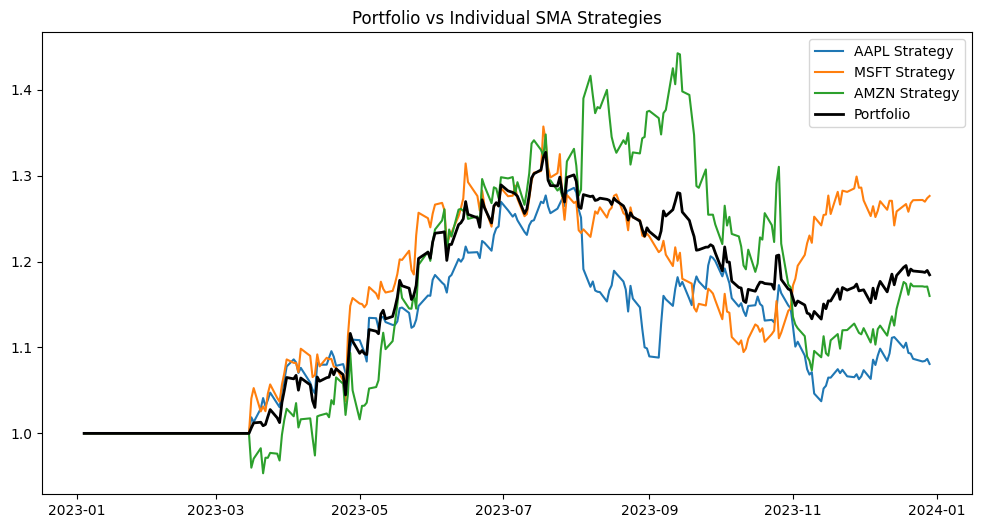

In [7]:
# Step 7: Visualize portfolio vs. single assets
#We plot cumulative returns to compare the portfolio against individual strategies. This shows the benefit of diversification.

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for t in tickers:
    plt.plot((1 + results[t]["Strategy_Return"]).cumprod(), label=f"{t} Strategy")
plt.plot(portfolio["Cumulative"], label="Portfolio", linewidth=2, color="black")
plt.title("Portfolio vs Individual SMA Strategies")
plt.legend()
plt.show()


In [8]:
# Step 8: Save logs
#We save results to `/logs/` so we maintain an **audit trail** of both portfolio and individual performance.

import os
from datetime import datetime

os.makedirs("../logs", exist_ok=True)
all_metrics.to_csv("../logs/Day9_portfolio_metrics.csv", index=False)
portfolio.to_csv("../logs/Day9_portfolio_curve.csv")

with open("../logs/Day9_summary.txt", "w") as f:
    f.write(f"Day 9 run ({datetime.today().date()})\n")
    f.write(all_metrics.to_string())

